# Live demo: Processing gravity data with Fatiando a Terra

This notebook is based on the [Harmonica tutorial](https://github.com/fatiando/transform21) during [Transform21](https://softwareunderground.org/transform).

## Import packages

In [1]:
import pygmt
import pyproj
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import pooch
import verde as vd
import boule as bl
import harmonica as hm

## Load Bushveld Igneous Complex gravity data (South Africa) and a DEM

We can use [Pooch](https://www.fatiando.org/pooch) to download data files from anywhere in the web.
Let's download some gravity data from the Bushveld Igneous Complex:

In [2]:
url = "https://github.com/fatiando/2021-gsh/main/raw/notebook/data/bushveld_gravity.csv"
md5_hash = "md5:45539f7945794911c6b5a2eb43391051"

In [3]:
fname = pooch.retrieve(url, known_hash=md5_hash, fname="bushveld_gravity.csv")
fname

'/home/santi/.cache/pooch/bushveld_gravity.csv'

And use Pandas for reading the csv file

In [4]:
data = pd.read_csv(fname)
data

,latitude,longitude,elevation,gravity
0,-26.26334,25.01500,1230.16,978681.38
1,-26.38713,25.01932,1297.00,978669.02
2,-26.39667,25.02499,1304.84,978669.28
3,-26.07668,25.04500,1165.24,978681.08
4,-26.35001,25.07668,1262.47,978665.19
...,...,...,...,...
3872,-23.86333,31.51500,300.53,978776.85
3873,-23.30000,31.52499,280.72,978798.55
3874,-23.19333,31.54832,245.67,978803.55
3875,-23.84833,31.57333,226.77,978808.44


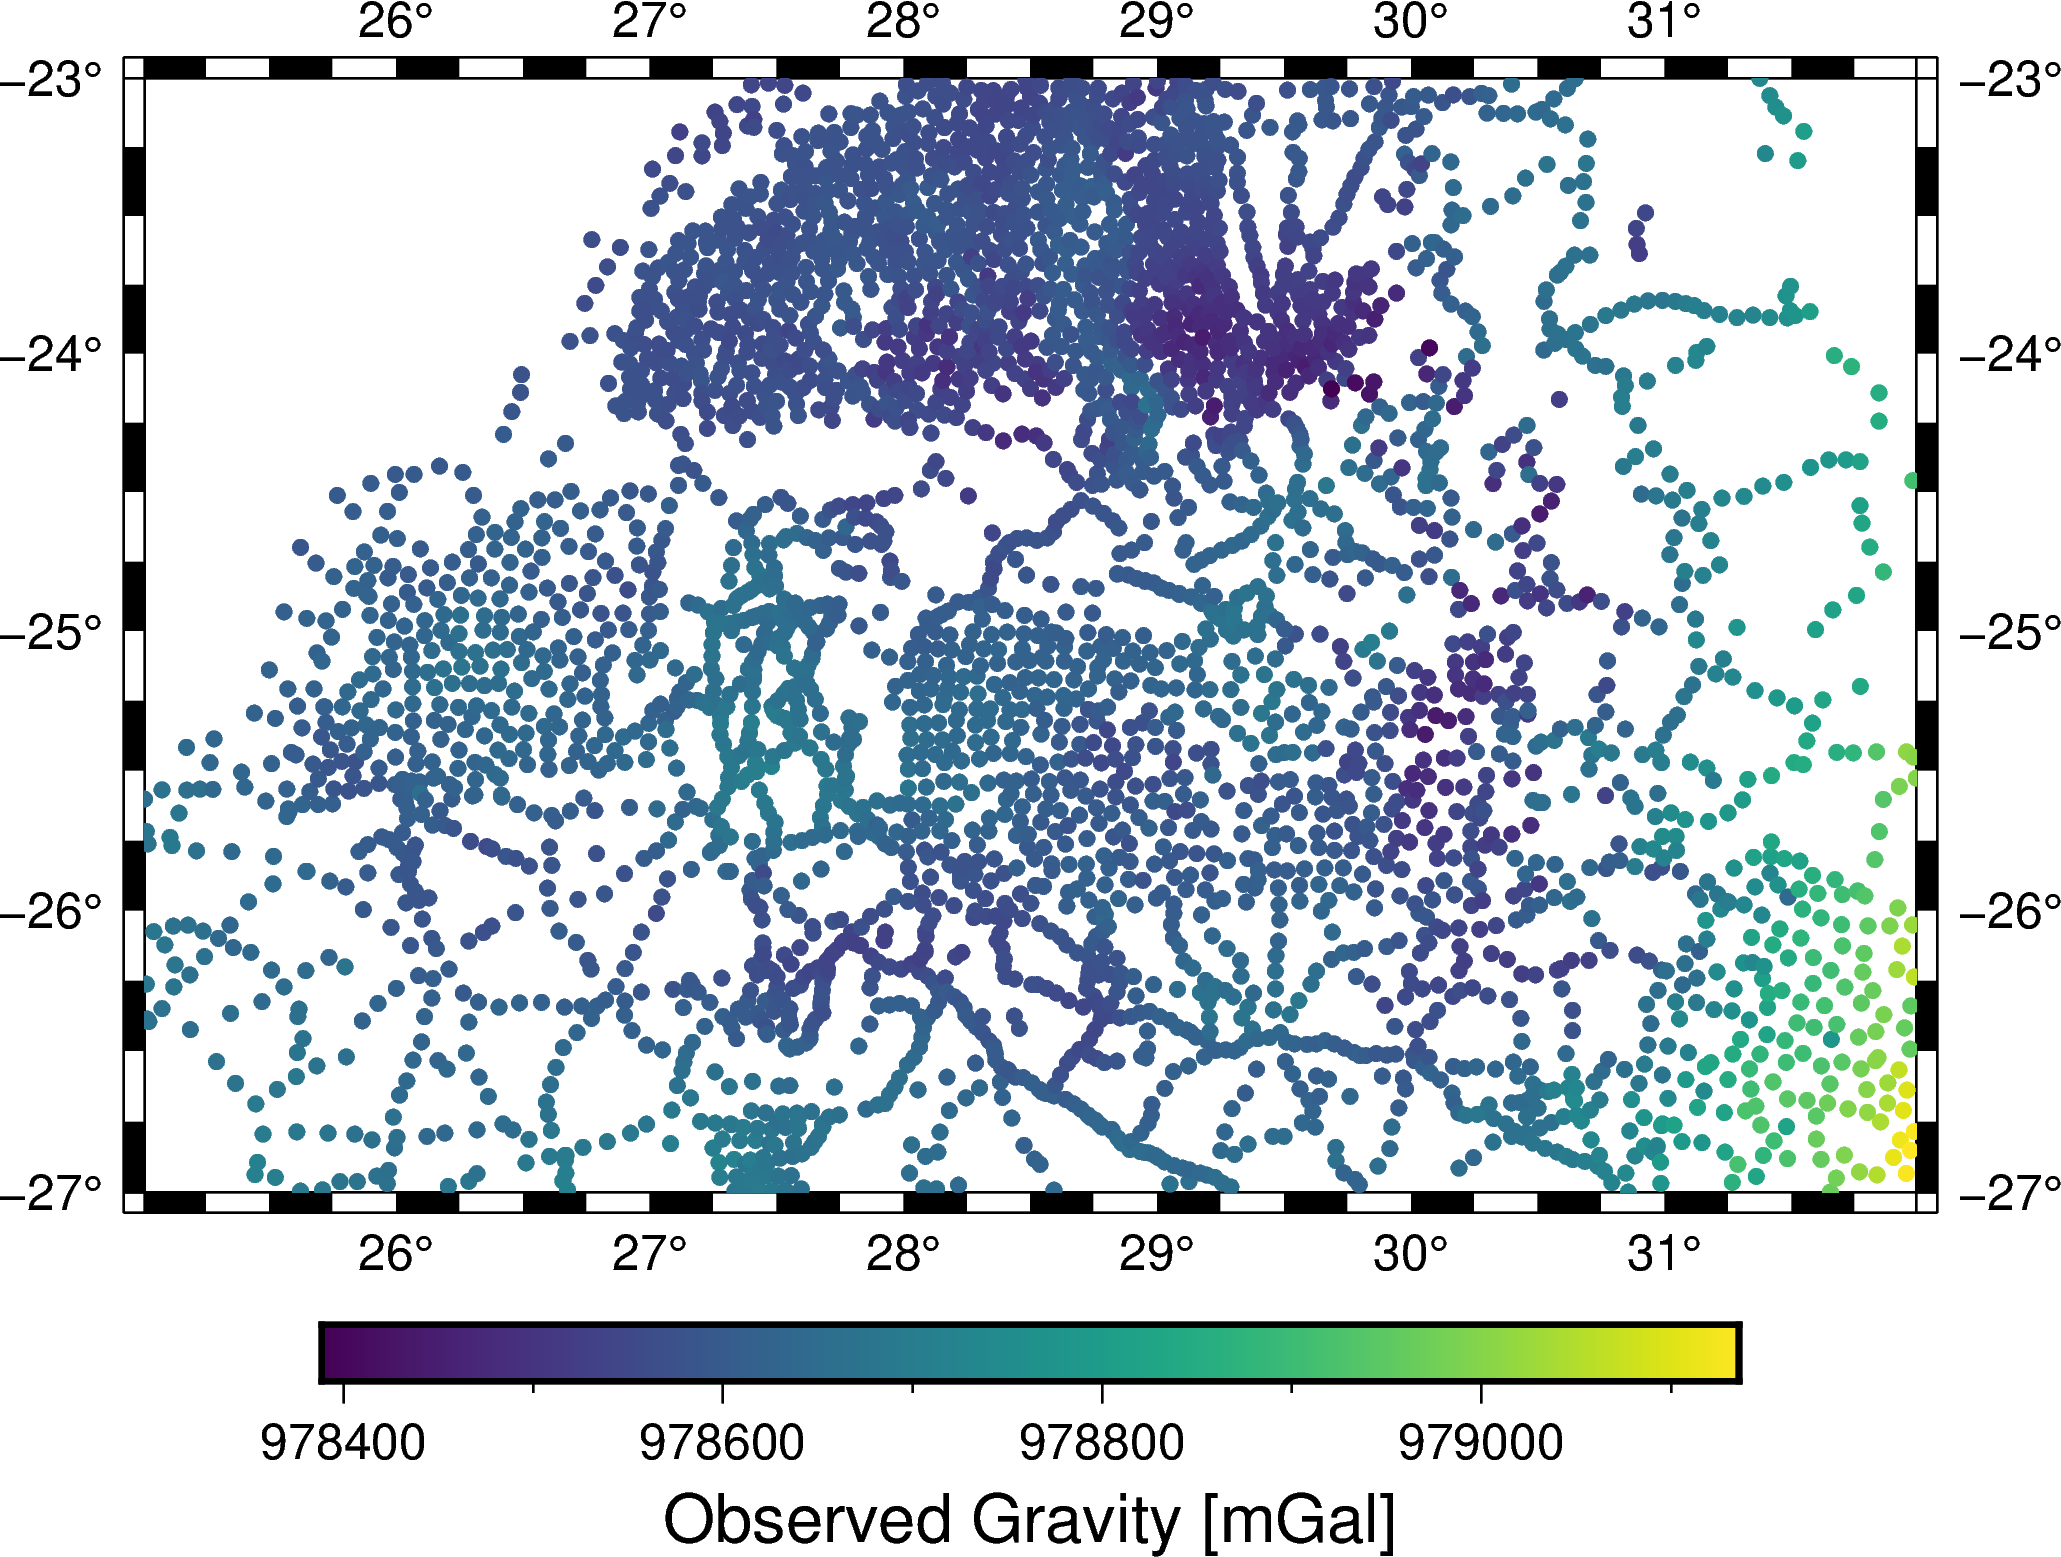

In [5]:
# Obtain the region to plot using Verde ([W, E, S, N])
region_deg = vd.get_region((data.longitude, data.latitude))

fig = pygmt.Figure()
fig.basemap(projection="M15c", region=region_deg, frame=True)
pygmt.makecpt(cmap="viridis", series=[data.gravity.min(), data.gravity.max()])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.gravity,
    cmap=True,
    style="c4p",
)
fig.colorbar(frame='af+l"Observed Gravity [mGal]"')
fig.show()

Let's download a DEM for the same area:

In [6]:
url = "https://github.com/fatiando/transform21/raw/main/data/bushveld_topography.nc"
md5_hash = "md5:62daf6a114dda89530e88942aa3b8c41"

fname = pooch.retrieve(url, known_hash=md5_hash, fname="bushveld_topography.nc")
fname

'/home/santi/.cache/pooch/bushveld_topography.nc'

And use Xarray to load the netCDF file:

In [7]:
topography = xr.load_dataarray(fname)
topography

<xarray.DataArray 'bedrock' (latitude: 240, longitude: 419)>
array([[1257., 1260., 1266., ...,  195.,  201.,  425.],
       [1245., 1254., 1261., ...,  206.,  215.,  375.],
       [1256., 1258., 1268., ...,  200.,  232.,  300.],
       ...,
       [1029., 1031., 1033., ...,  248.,  242.,  238.],
       [1029., 1031., 1033., ...,  247.,  242.,  237.],
       [1028., 1030., 1032., ...,  247.,  241.,  238.]])
Coordinates:
  * longitude  (longitude) float64 25.02 25.03 25.05 25.07 ... 31.95 31.97 31.98
  * latitude   (latitude) float64 -27.0 -26.98 -26.97 ... -23.05 -23.03 -23.02
Attributes:
    long_name:       Bedrock relief
    actual_range:    [-10898.   8271.]
    units:           meters
    vertical_datum:  sea level
    datum:           WGS84

grdinfo [WARNING]: The x-coordinates and range attribute are in conflict but range is exactly 360; we rely on this range
grdinfo [WARNING]: The y-coordinates and range attribute are in conflict but range is exactly 180; we rely on this range


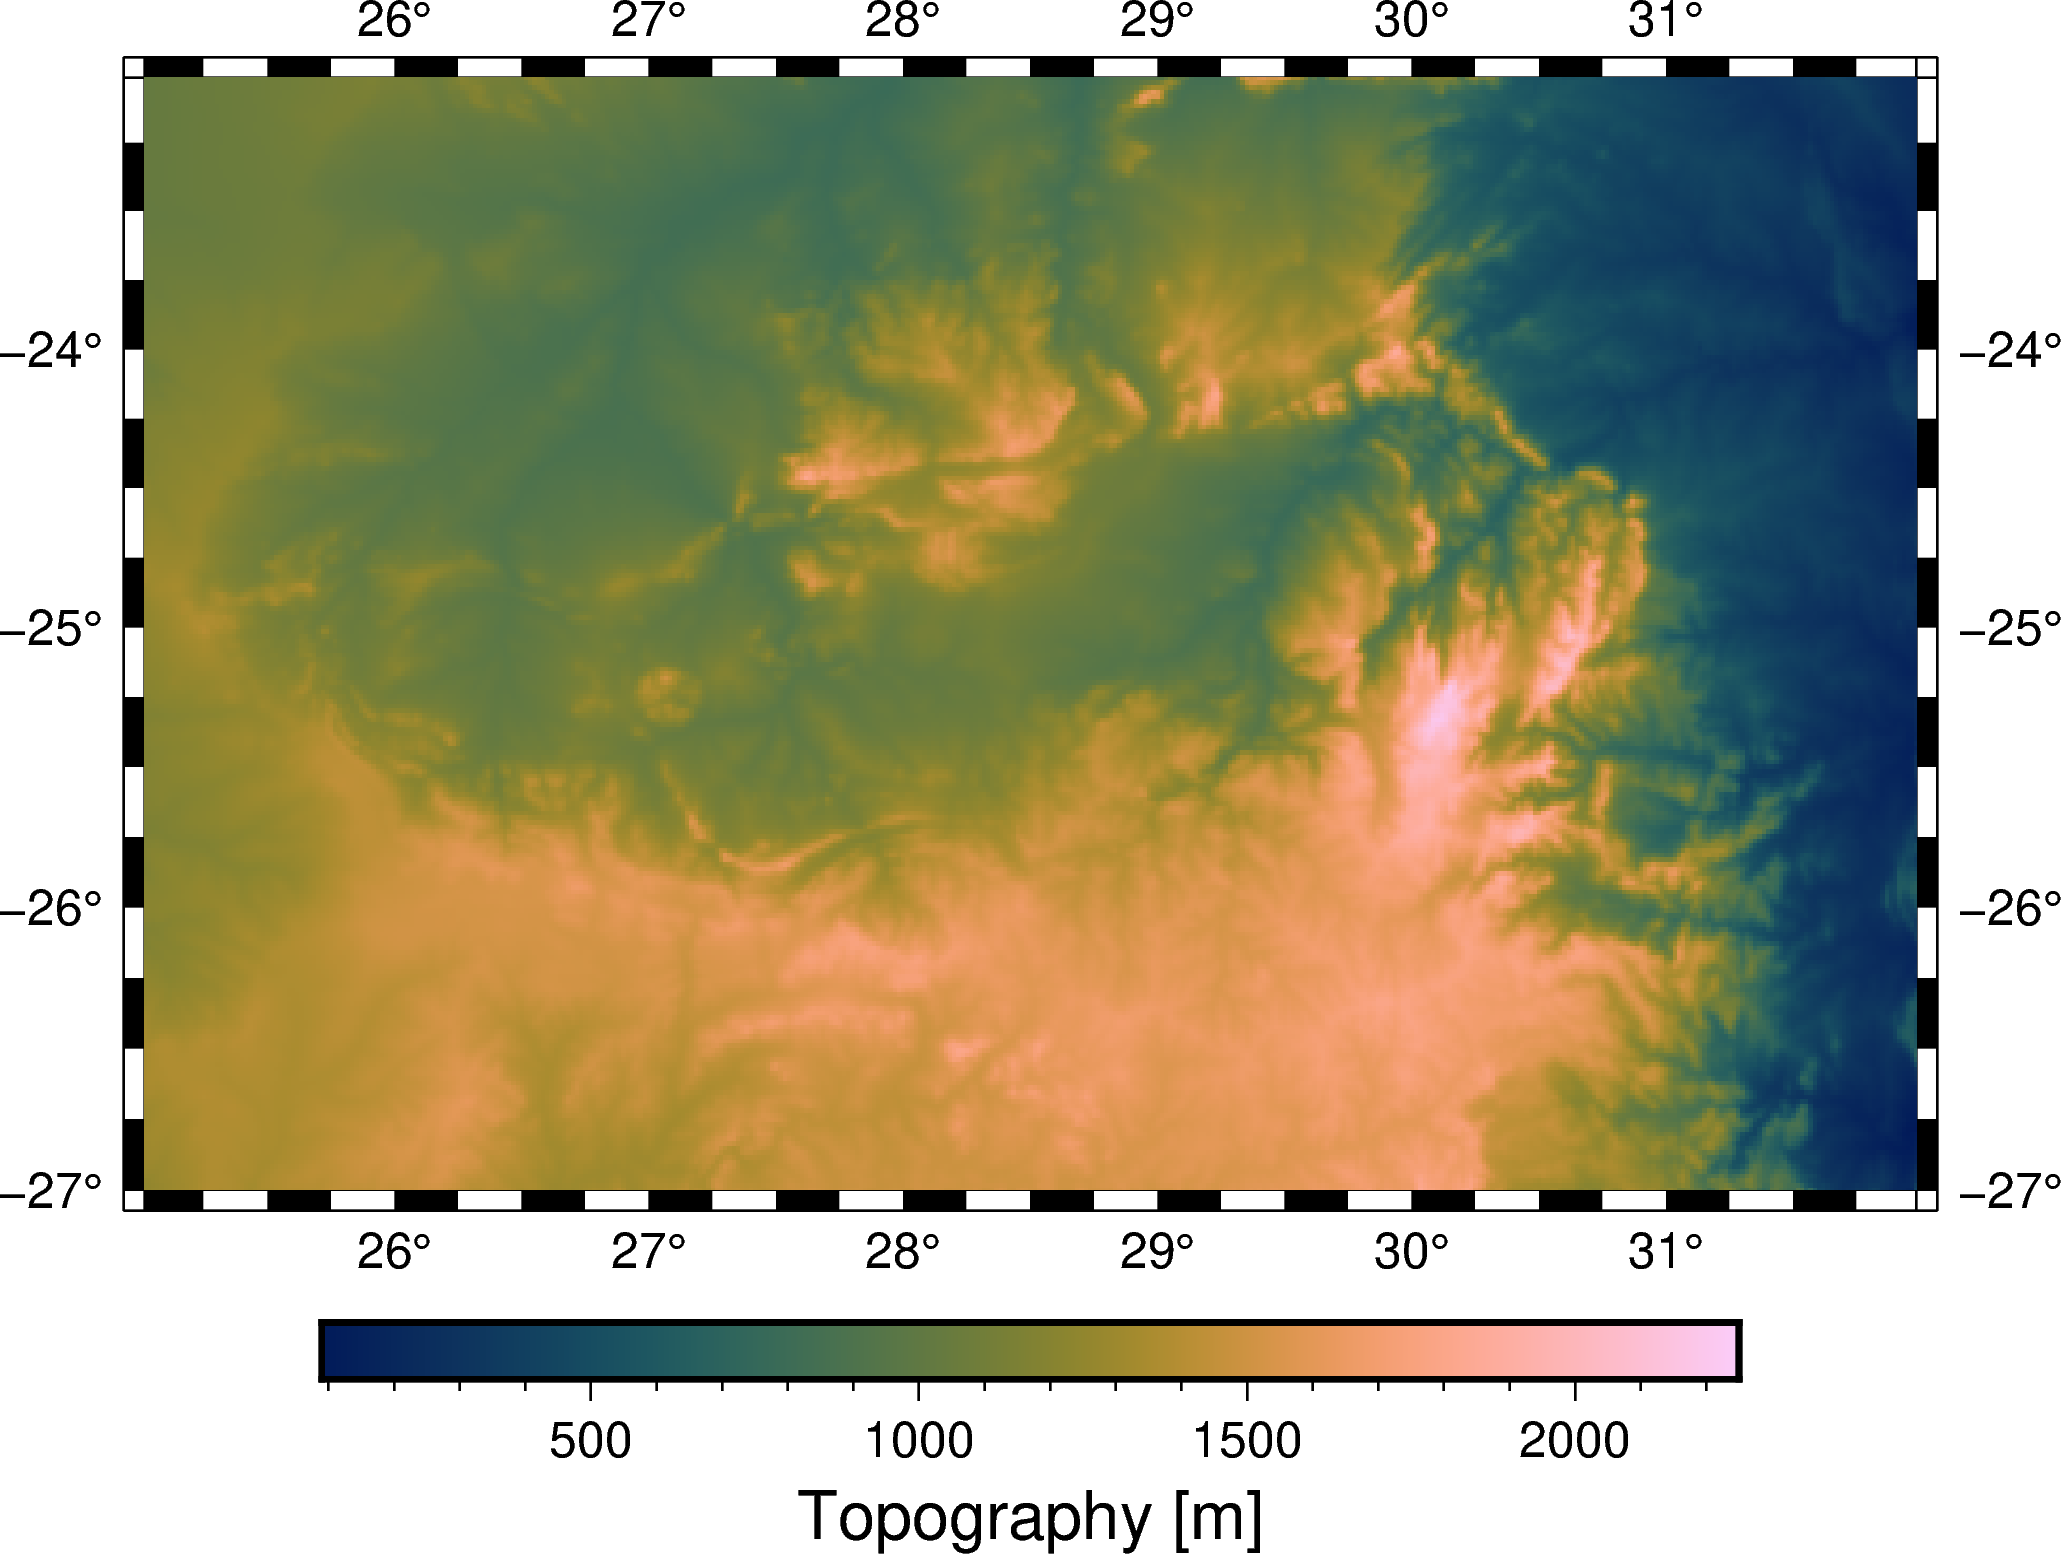

In [8]:
# Plot topography using pygmt
topo_region = vd.get_region((topography.longitude.values, topography.latitude.values))

fig = pygmt.Figure()
topo_region = vd.get_region((topography.longitude.values, topography.latitude.values))
fig.basemap(projection="M15c", region=topo_region, frame=True)

vmin, vmax = topography.values.min(), topography.values.max()
pygmt.makecpt(cmap="batlow", series=[vmin, vmax])
fig.grdimage(topography)

fig.colorbar(frame='af+l"Topography [m]"')
fig.show()

## Compute gravity disturbance

We can use [Boule](https://www.fatiando.org/boule) for computing the normal gravity of the WGS84 reference ellipsoid on any point.

In [9]:
ellipsoid = bl.WGS84
normal_gravity = ellipsoid.normal_gravity(data.latitude, data.elevation)
normal_gravity

0       978664.725301
1       978652.988542
2       978651.255750
3       978671.414340
4       978660.974215
            ...      
3872    978785.393559
3873    978754.230966
3874    978758.068460
3875    978807.159627
3876    978733.156141
Length: 3877, dtype: float64

And compute the gravity disturbance as the difference between the observed gravity and the normal gravity:

In [10]:
data["disturbance"] = data.gravity - normal_gravity
data

,latitude,longitude,elevation,gravity,disturbance
0,-26.26334,25.01500,1230.16,978681.38,16.654699
1,-26.38713,25.01932,1297.00,978669.02,16.031458
2,-26.39667,25.02499,1304.84,978669.28,18.024250
3,-26.07668,25.04500,1165.24,978681.08,9.665660
4,-26.35001,25.07668,1262.47,978665.19,4.215785
...,...,...,...,...,...
3872,-23.86333,31.51500,300.53,978776.85,-8.543559
3873,-23.30000,31.52499,280.72,978798.55,44.319034
3874,-23.19333,31.54832,245.67,978803.55,45.481540
3875,-23.84833,31.57333,226.77,978808.44,1.280373


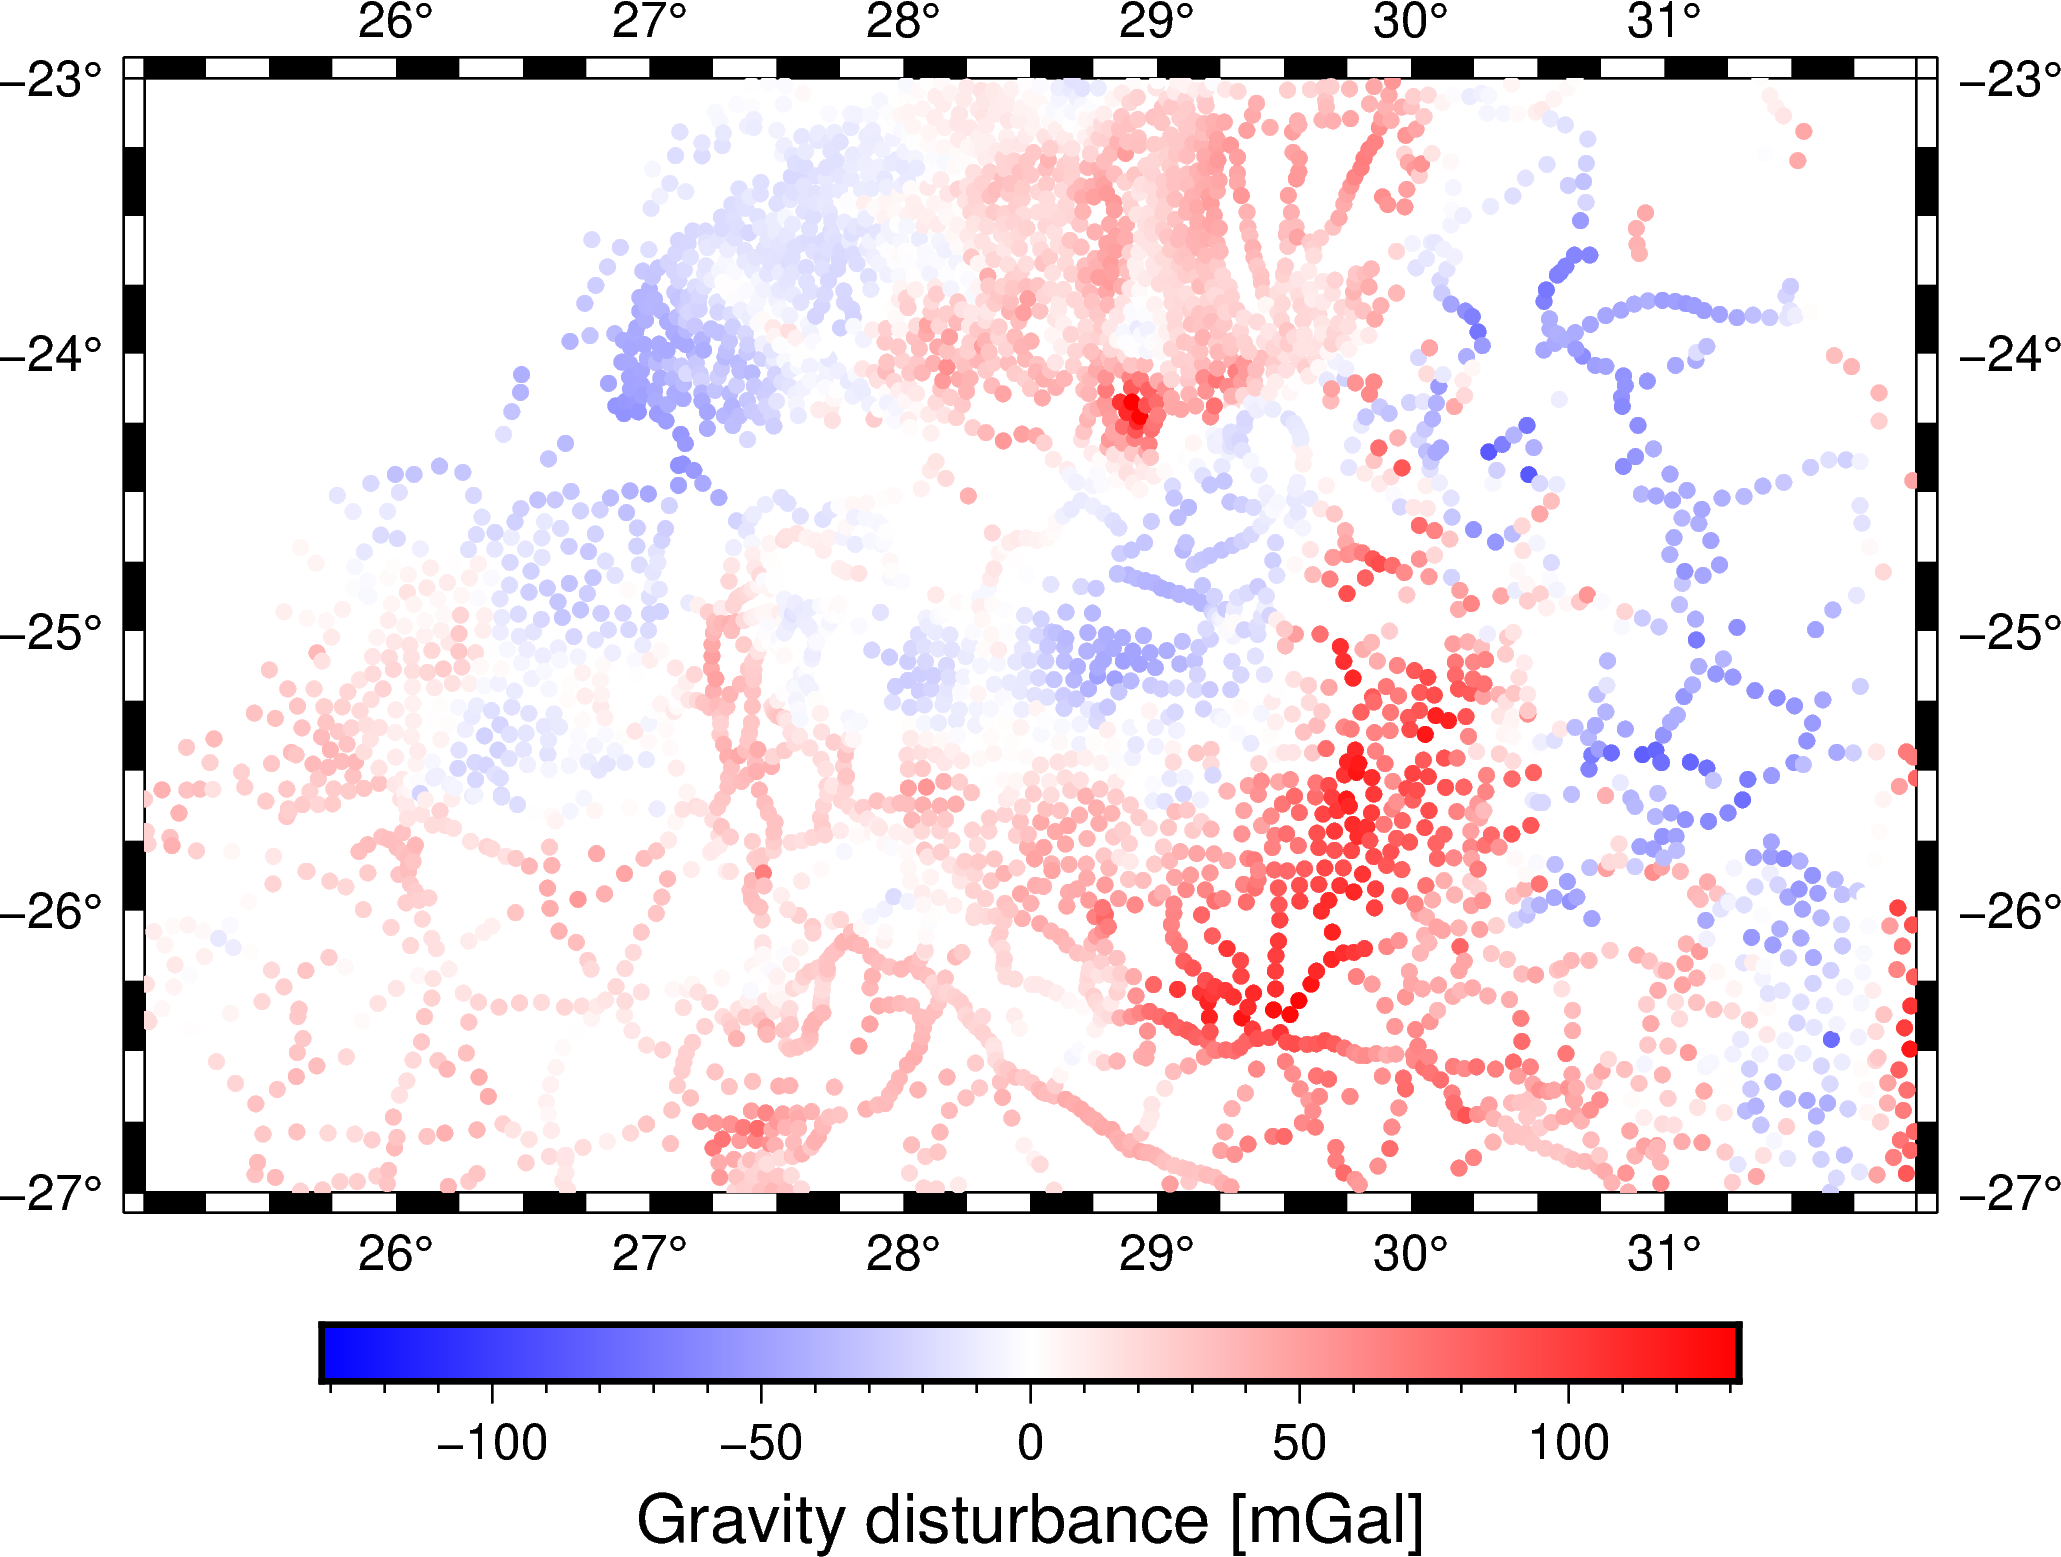

In [11]:
fig = pygmt.Figure()
fig.basemap(projection="M15c", region=region_deg, frame=True)

maxabs = vd.maxabs(data.disturbance)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.disturbance,
    cmap=True,
    style="c4p",
)

fig.colorbar(frame='af+l"Gravity disturbance [mGal]"')
fig.show()

## Remove terrain correction

We can use [Harmonica](https://www.fatiando.org/harmonica) for forward modelling the gravitational effect of the terrain through rectangular prisms.
To do so we need to project the coordinates of the data and the DEM to plain coordinates.

### Project the data to plain coordinates

Define the Mercator projeciton using `pyproj`:

In [12]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())

In [13]:
easting, northing = projection(data.longitude.values, data.latitude.values)

In [14]:
data["easting"] = easting
data["northing"] = northing
data

,latitude,longitude,elevation,gravity,disturbance,easting,northing
0,-26.26334,25.01500,1230.16,978681.38,16.654699,2.526066e+06,-2.733052e+06
1,-26.38713,25.01932,1297.00,978669.02,16.031458,2.526503e+06,-2.746924e+06
2,-26.39667,25.02499,1304.84,978669.28,18.024250,2.527075e+06,-2.747994e+06
3,-26.07668,25.04500,1165.24,978681.08,9.665660,2.529096e+06,-2.712163e+06
4,-26.35001,25.07668,1262.47,978665.19,4.215785,2.532295e+06,-2.742763e+06
...,...,...,...,...,...,...,...
3872,-23.86333,31.51500,300.53,978776.85,-8.543559,3.182450e+06,-2.466945e+06
3873,-23.30000,31.52499,280.72,978798.55,44.319034,3.183459e+06,-2.405224e+06
3874,-23.19333,31.54832,245.67,978803.55,45.481540,3.185814e+06,-2.393567e+06
3875,-23.84833,31.57333,226.77,978808.44,1.280373,3.188340e+06,-2.465298e+06


### Project the topography to plain coordinates

In [15]:
topo_plain = vd.project_grid(topography, projection=projection)
topo_plain

<xarray.DataArray 'bedrock' (northing: 240, easting: 419)>
array([[1257.        , 1260.        , 1266.        , ...,  202.        ,
         201.        ,  425.        ],
       [1245.19963571, 1254.09981785, 1261.08318154, ...,  211.10042501,
         214.76709167,  375.83181545],
       [1255.63559308, 1257.86748839, 1267.76810468, ...,  207.49691853,
         231.43682566,  302.48459266],
       ...,
       [1029.03190101, 1031.        , 1033.03190101, ...,  248.70920135,
         242.03190101,  238.03190101],
       [1028.67199134, 1030.67199134, 1032.67199134, ...,  247.57330446,
         241.67199134,  237.67199134],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])
Coordinates:
  * easting   (easting) float64 2.526e+06 2.528e+06 ... 3.228e+06 3.23e+06
  * northing  (northing) float64 -2.816e+06 -2.814e+06 ... -2.376e+06 -2.374e+06
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

### Compute gravitational effect of the layer of prisms

Create a model of the terrain with prisms

![](images/prisms.svg)

In [16]:
topo_prisms = hm.prism_layer(
    coordinates=(topo_plain.easting, topo_plain.northing),
    surface=topo_plain.values,
    reference=0,
    properties={"density": 2670 * np.ones_like(topo_plain.values)}
)
topo_prisms

<xarray.Dataset>
Dimensions:   (easting: 419, northing: 240)
Coordinates:
  * easting   (easting) float64 2.526e+06 2.528e+06 ... 3.228e+06 3.23e+06
  * northing  (northing) float64 -2.816e+06 -2.814e+06 ... -2.376e+06 -2.374e+06
    top       (northing, easting) float64 1.257e+03 1.26e+03 ... nan nan
    bottom    (northing, easting) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables:
    density   (northing, easting) float64 2.67e+03 2.67e+03 ... 2.67e+03
Attributes:
    coords_units:      meters
    properties_units:  SI

Calculate the gravitational effect of the terrain

In [17]:
coordinates = (data.easting, data.northing, data.elevation)
terrain_effect = topo_prisms.prism_layer.gravity(coordinates, field="g_z")
terrain_effect

array([106.19250697, 120.6991267 , 128.8345669 , ...,  25.41503277,
        23.42737391,   0.44732757])

Calculate the Bouguer disturbance

In [18]:
data["bouguer"] = data.disturbance - terrain_effect
data

,latitude,longitude,elevation,gravity,disturbance,easting,northing,bouguer
0,-26.26334,25.01500,1230.16,978681.38,16.654699,2.526066e+06,-2.733052e+06,-89.537808
1,-26.38713,25.01932,1297.00,978669.02,16.031458,2.526503e+06,-2.746924e+06,-104.667669
2,-26.39667,25.02499,1304.84,978669.28,18.024250,2.527075e+06,-2.747994e+06,-110.810317
3,-26.07668,25.04500,1165.24,978681.08,9.665660,2.529096e+06,-2.712163e+06,-112.745499
4,-26.35001,25.07668,1262.47,978665.19,4.215785,2.532295e+06,-2.742763e+06,-132.654914
...,...,...,...,...,...,...,...,...
3872,-23.86333,31.51500,300.53,978776.85,-8.543559,3.182450e+06,-2.466945e+06,-41.557479
3873,-23.30000,31.52499,280.72,978798.55,44.319034,3.183459e+06,-2.405224e+06,14.646066
3874,-23.19333,31.54832,245.67,978803.55,45.481540,3.185814e+06,-2.393567e+06,20.066507
3875,-23.84833,31.57333,226.77,978808.44,1.280373,3.188340e+06,-2.465298e+06,-22.147000


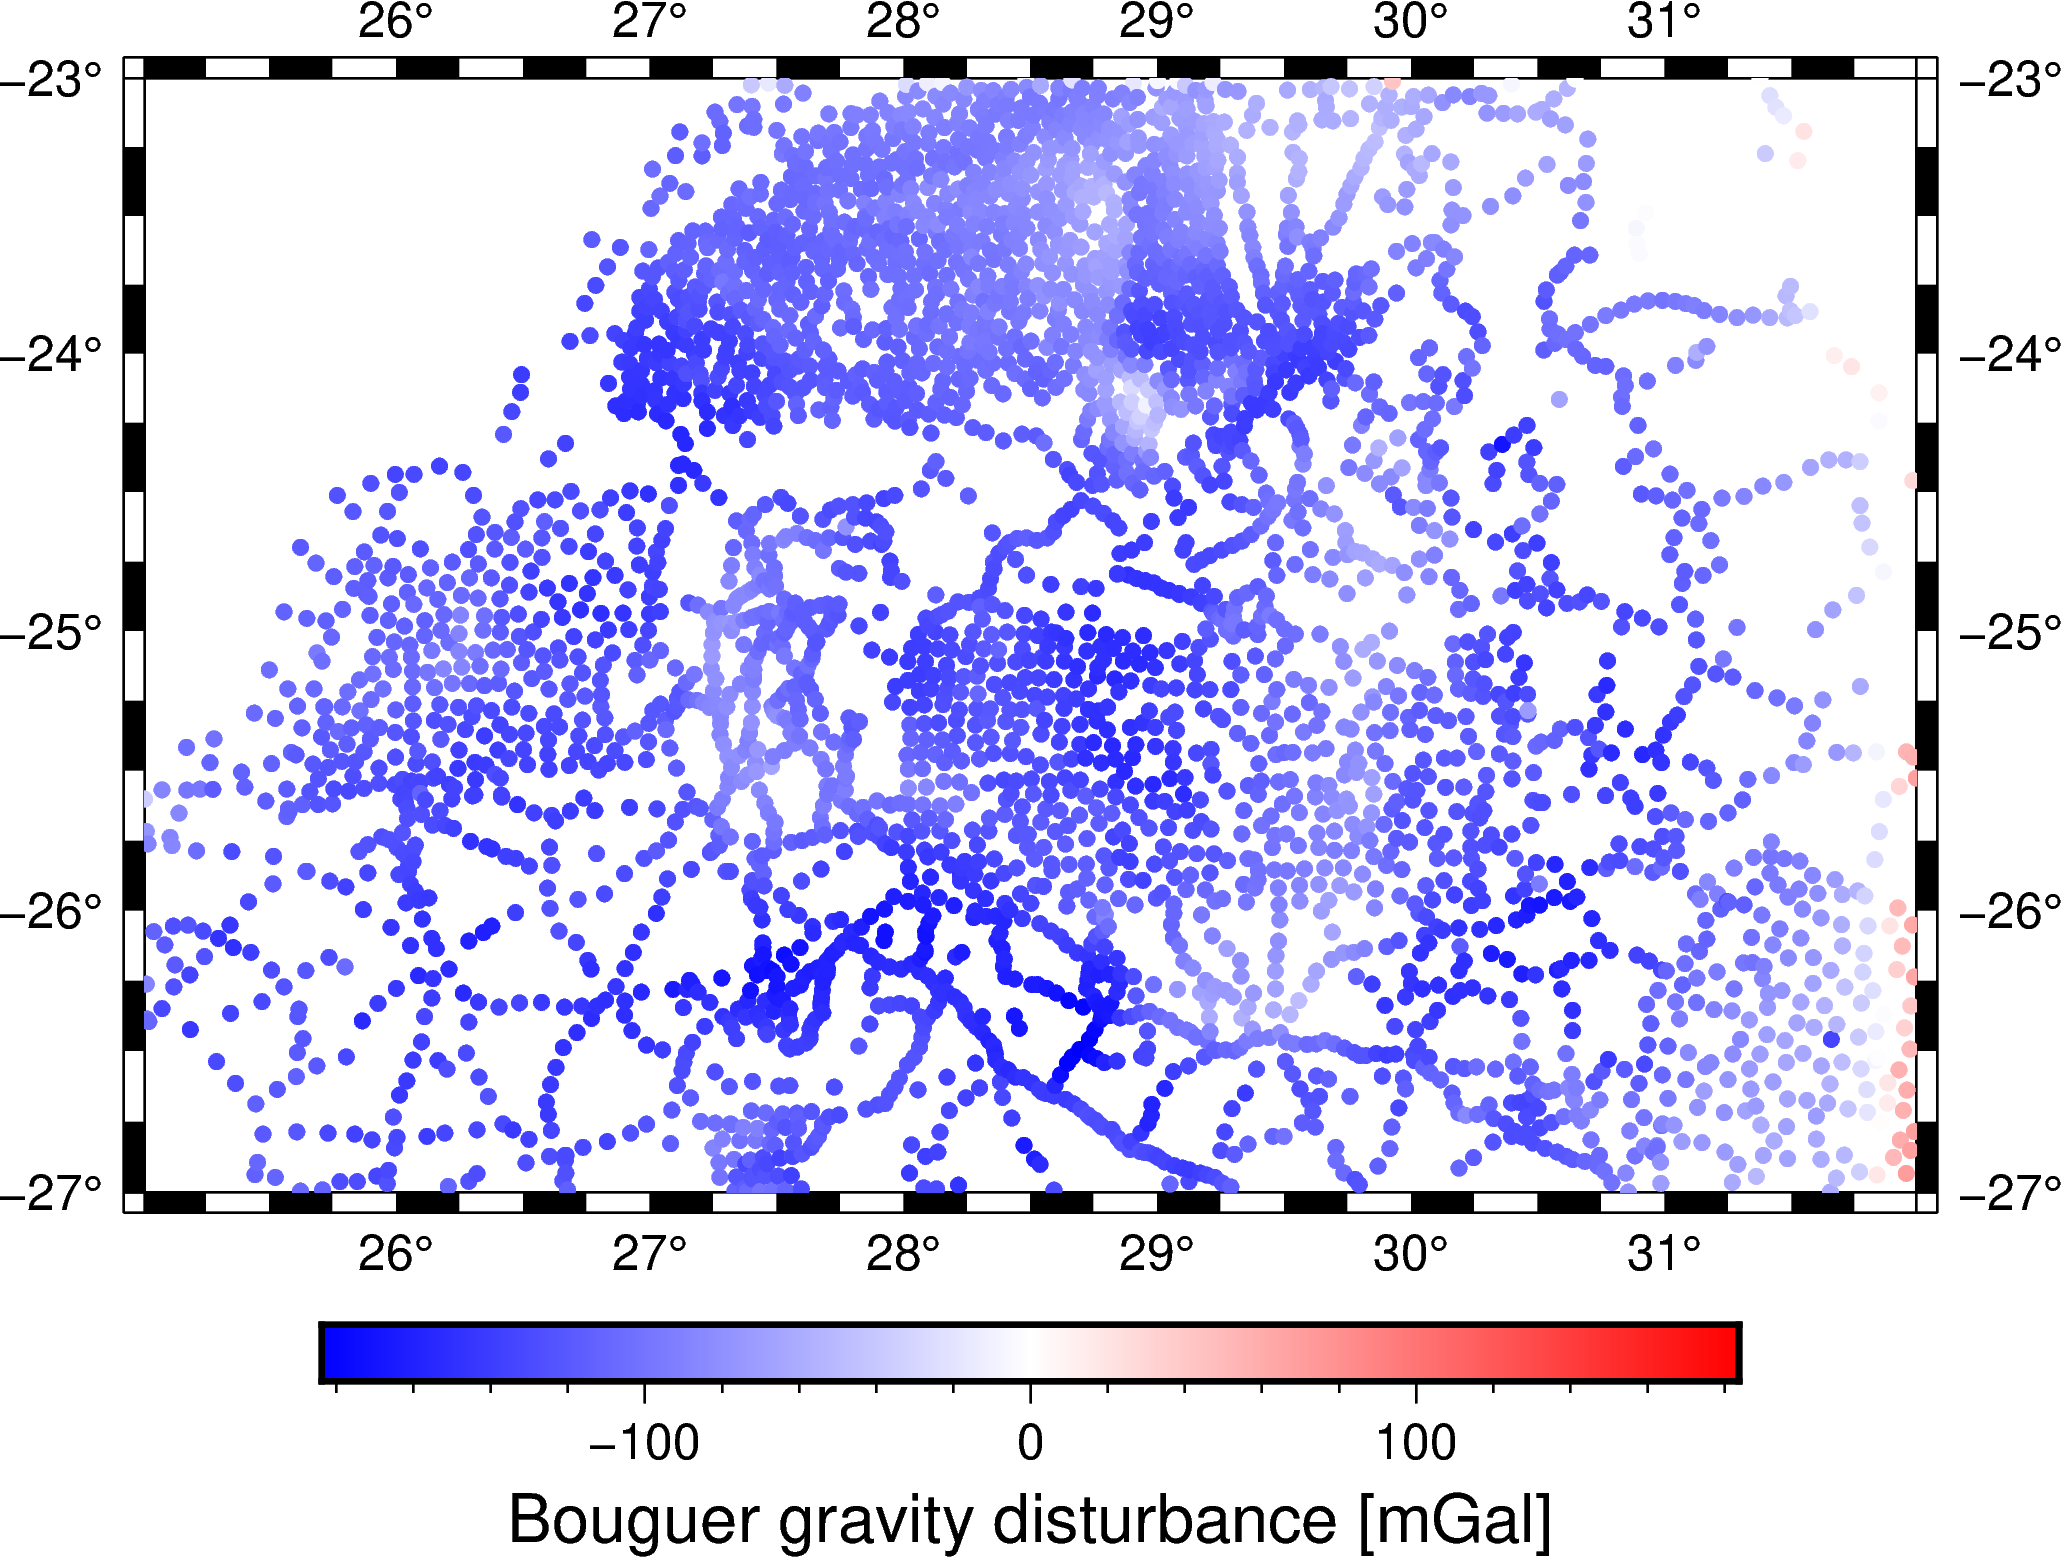

In [19]:
fig = pygmt.Figure()
fig.basemap(projection="M15c", region=region_deg, frame=True)

maxabs = vd.maxabs(data.bouguer)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.bouguer,
    cmap=True,
    style="c4p",
)
fig.colorbar(frame='af+l"Bouguer gravity disturbance [mGal]"')
fig.show()

## Calculate residuals

We can use [Verde](https://www.fatiando.org/verde) to remove a second degree trend from the Bouguer disturbance

In [20]:
trend = vd.Trend(degree=2).fit(coordinates, data.bouguer).predict(coordinates)
residuals = data.bouguer - trend

In [21]:
data["residuals"] = residuals
data

,latitude,longitude,elevation,gravity,disturbance,easting,northing,bouguer,residuals
0,-26.26334,25.01500,1230.16,978681.38,16.654699,2.526066e+06,-2.733052e+06,-89.537808,20.742442
1,-26.38713,25.01932,1297.00,978669.02,16.031458,2.526503e+06,-2.746924e+06,-104.667669,5.452117
2,-26.39667,25.02499,1304.84,978669.28,18.024250,2.527075e+06,-2.747994e+06,-110.810317,-0.605386
3,-26.07668,25.04500,1165.24,978681.08,9.665660,2.529096e+06,-2.712163e+06,-112.745499,-1.861137
4,-26.35001,25.07668,1262.47,978665.19,4.215785,2.532295e+06,-2.742763e+06,-132.654914,-21.313972
...,...,...,...,...,...,...,...,...,...
3872,-23.86333,31.51500,300.53,978776.85,-8.543559,3.182450e+06,-2.466945e+06,-41.557479,15.856830
3873,-23.30000,31.52499,280.72,978798.55,44.319034,3.183459e+06,-2.405224e+06,14.646066,57.219681
3874,-23.19333,31.54832,245.67,978803.55,45.481540,3.185814e+06,-2.393567e+06,20.066507,58.807383
3875,-23.84833,31.57333,226.77,978808.44,1.280373,3.188340e+06,-2.465298e+06,-22.147000,33.265364


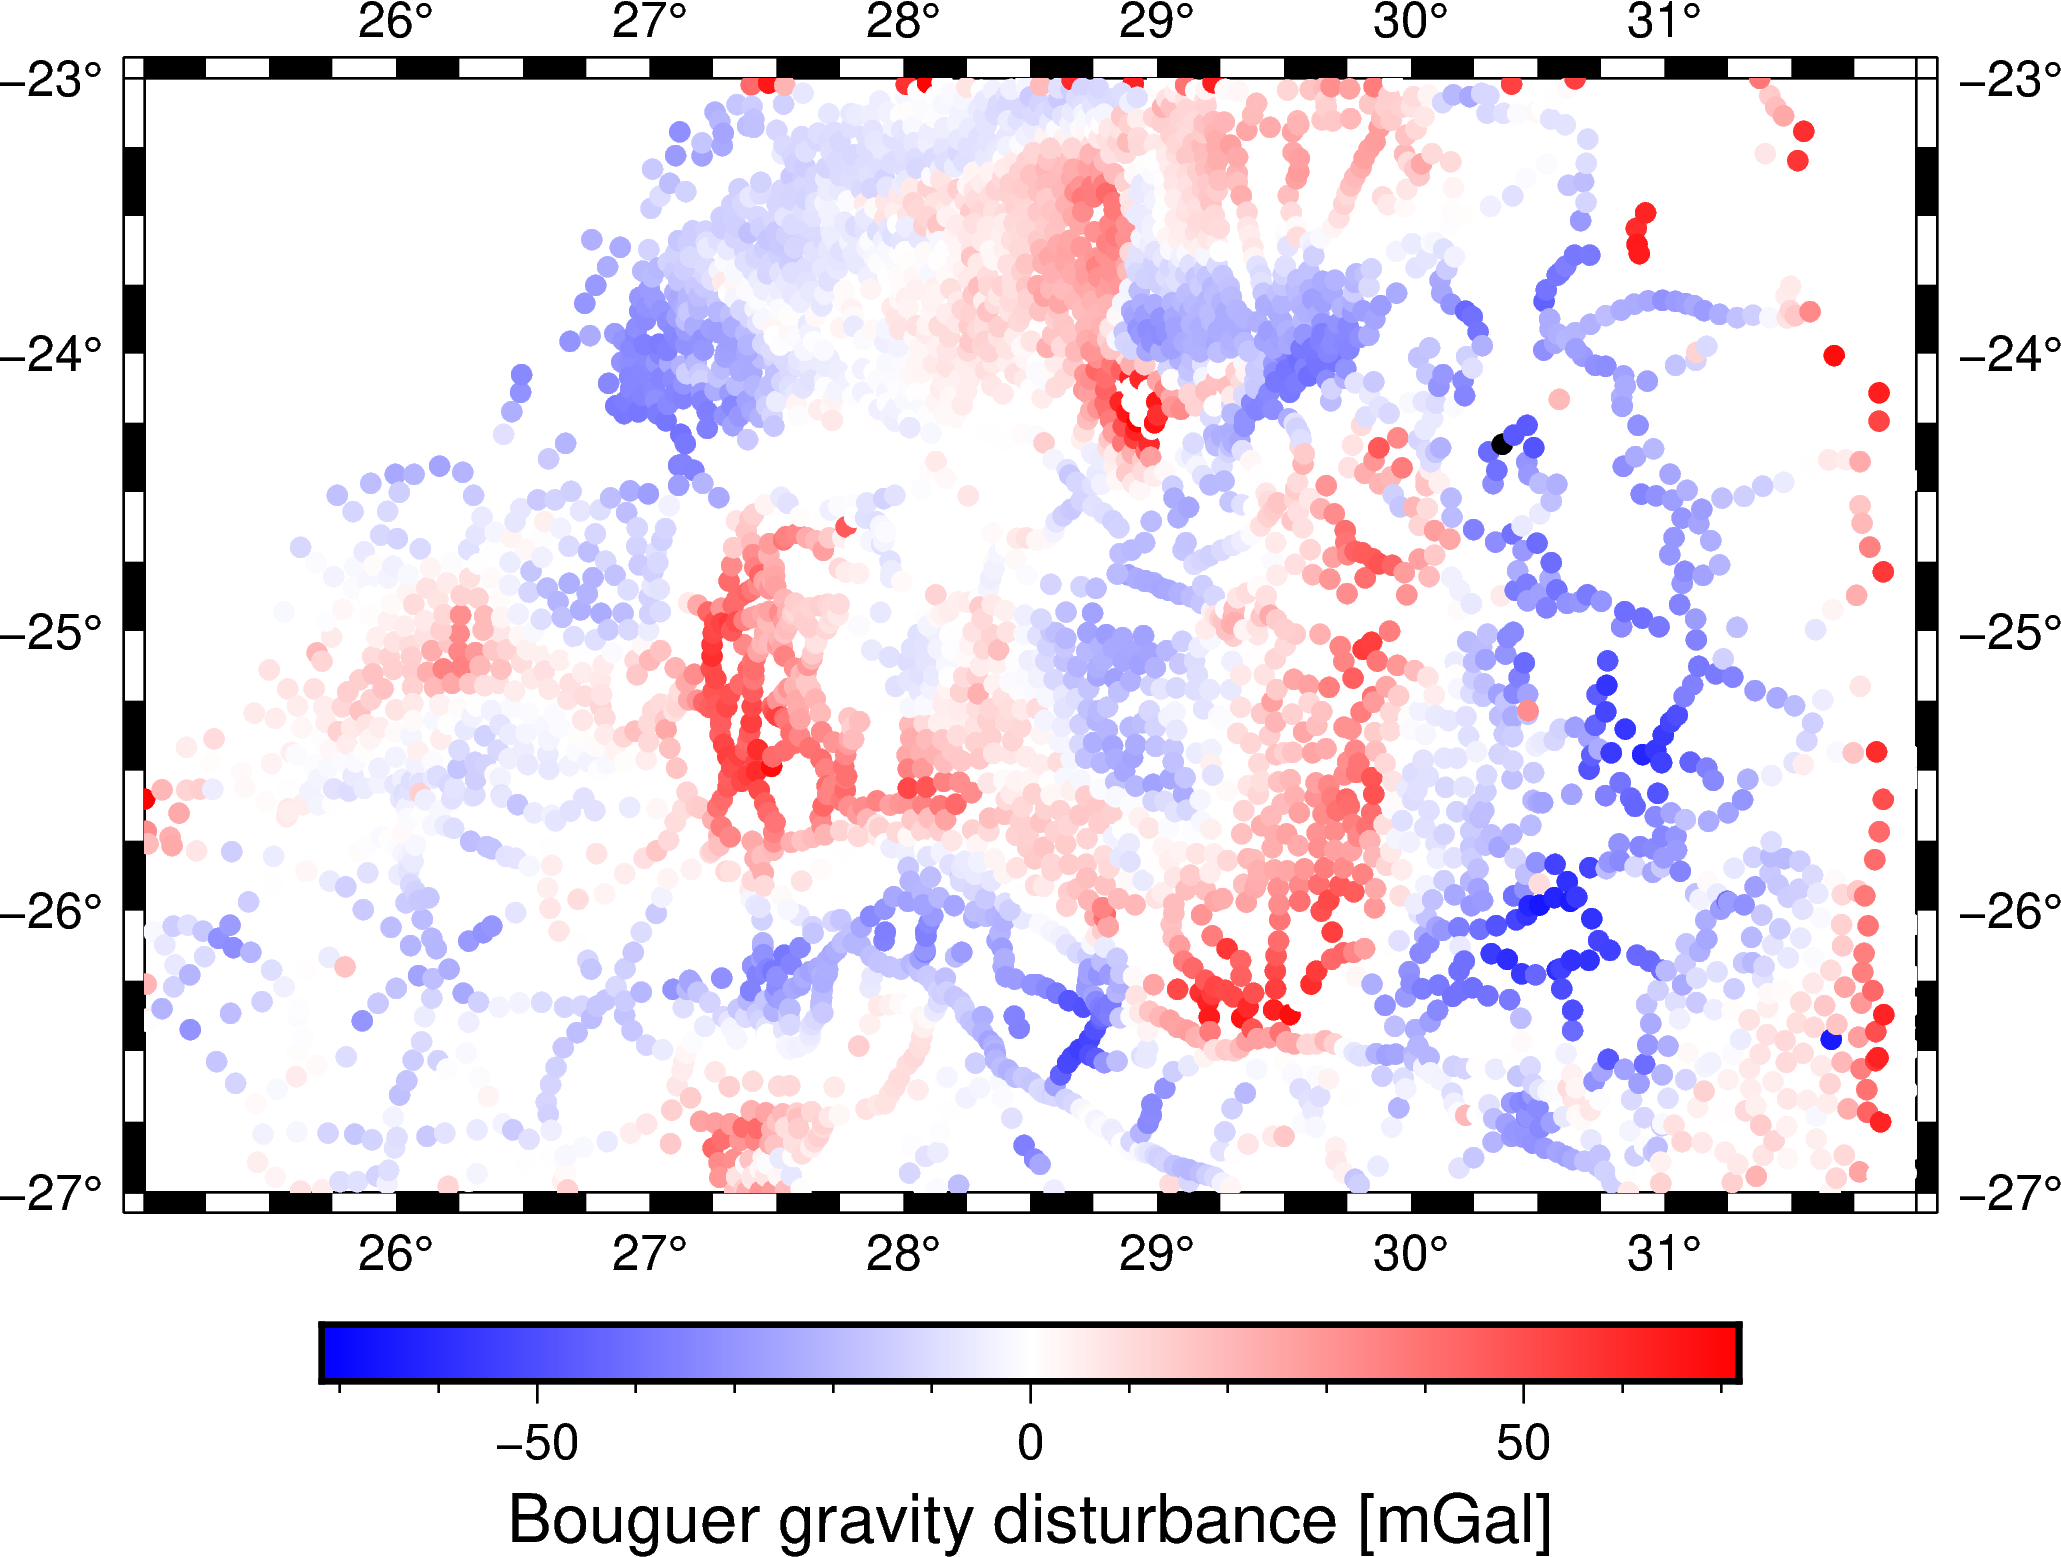

In [22]:
fig = pygmt.Figure()
fig.basemap(projection="M15c", region=region_deg, frame=True)

maxabs = np.quantile(np.abs(data.residuals), 0.99)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.residuals,
    cmap=True,
    style="c5p",
)
fig.colorbar(frame='af+l"Bouguer gravity disturbance [mGal]"')
fig.show()

## Grid the residuals with Equivalent Sources

We can use [Harmonica](https://www.fatiando.org/harmonica) to grid the residuals though the equivalent sources technique

![](images/eql.svg)

In [23]:
eql = hm.EQLHarmonic(damping=100, relative_depth=10e3)
eql.fit(coordinates, data.residuals)

EQLHarmonic(damping=100, relative_depth=10000.0)

In [24]:
grid = eql.grid(
    upward=2200,
    region=region_deg,
    spacing=0.01,
    data_names=["residuals"],
    dims=("latitude", "longitude"),
    projection=projection,
)
grid

<xarray.Dataset>
Dimensions:    (latitude: 401, longitude: 699)
Coordinates:
  * longitude  (longitude) float64 25.01 25.02 25.03 25.04 ... 31.97 31.98 31.99
  * latitude   (latitude) float64 -27.0 -26.99 -26.98 ... -23.02 -23.01 -23.0
    upward     (latitude, longitude) float64 2.2e+03 2.2e+03 ... 2.2e+03 2.2e+03
Data variables:
    residuals  (latitude, longitude) float64 -0.7817 -0.7904 ... 16.86 16.7
Attributes:
    metadata:  Generated by EQLHarmonic(damping=100, relative_depth=10000.0)

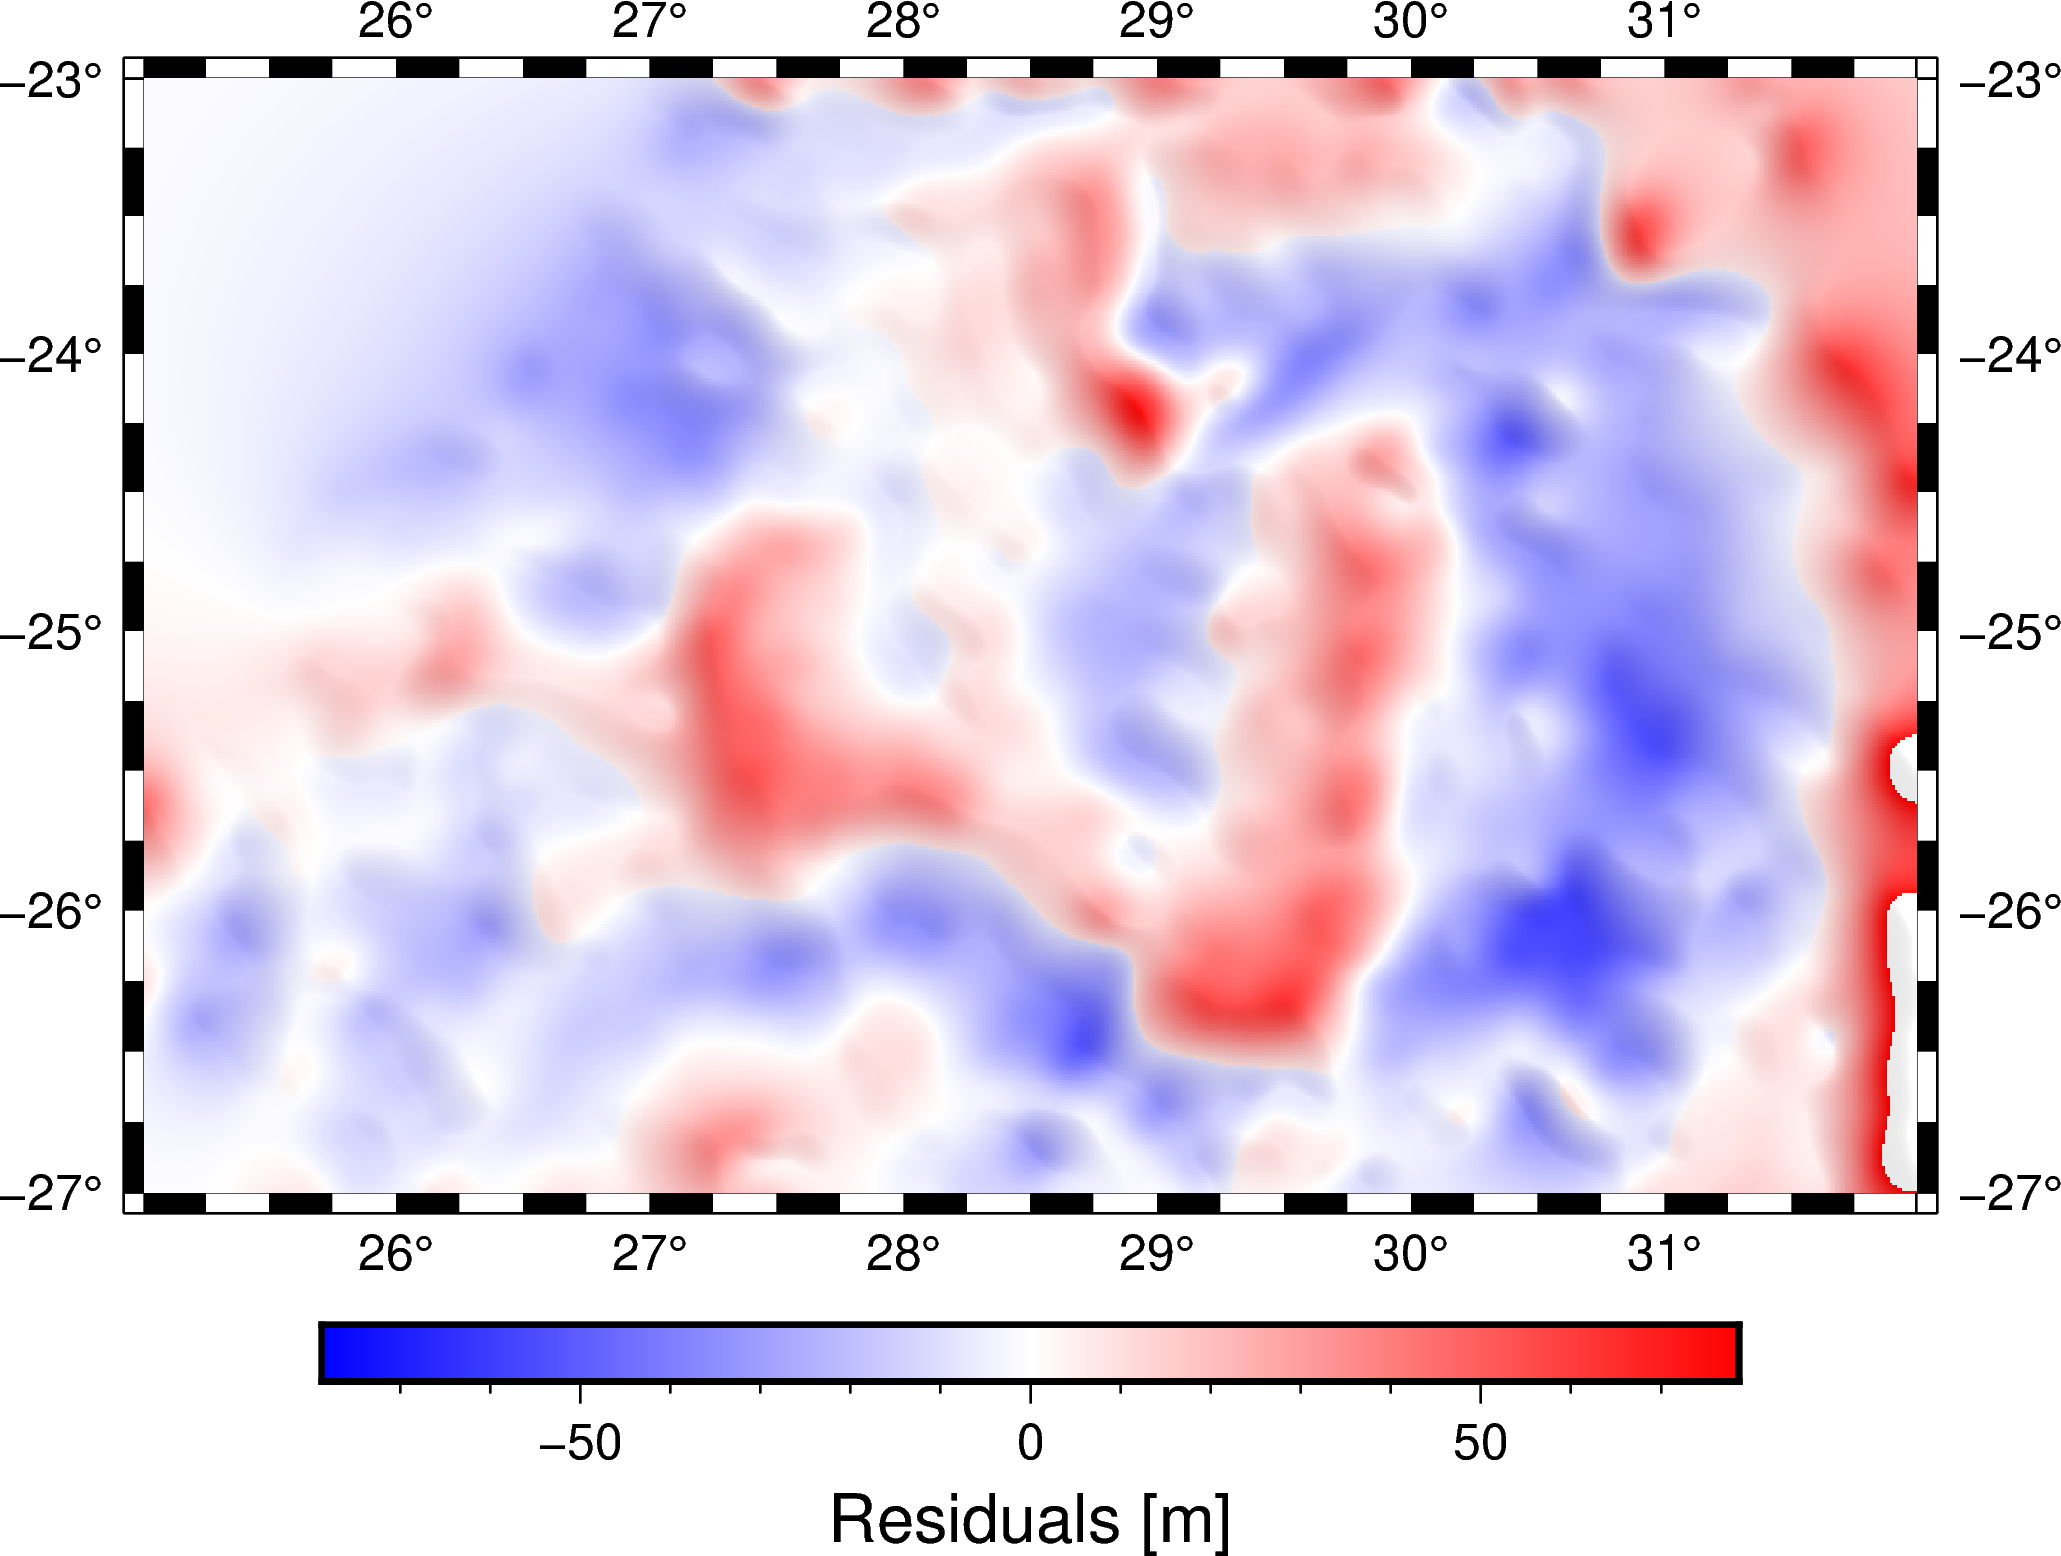

In [25]:
fig = pygmt.Figure()
fig.basemap(projection="M15c", region=region_deg, frame=True)

scale = np.quantile(np.abs(grid.residuals), 0.995)
pygmt.makecpt(cmap="polar", series=[-scale, scale], no_bg=True)
fig.grdimage(
    grid.residuals,
    shading="+a45+nt0.15",
    cmap=True,
)
fig.colorbar(frame='af+l"Residuals [m]"')
fig.show()